# Plot density

In [1]:
library(tidyverse)
library(readxl)
library(stringr)

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
Warning message:
“Failed to locate timezone database”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
getwd()

[1] "/home/memory_fzq/work/other/202501YHX"

In [ ]:
setwd("work/other/202501YHX/")

## Prepare data

In [4]:
excel_file <- "副本BLA-PFC-LC的分区3.xlsx"
sheet_name <- "计算均值 作图"
label_range <- "A2:A41"
ranges <- list(
    `PFC-LC` = "B2:E41",
    `BLA-PFC` = "J2:M41",
    colabel = "R2:U41"
)

In [5]:
dist_ranges <- read_excel(
    path = excel_file,
    sheet = sheet_name,
    range = label_range,
    col_names = "distance"
) %>% separate(
    distance, into = c("min_distance", "max_distance"), sep = "-",
    remove = FALSE
) %>% mutate(across(c(min_distance, max_distance), as.numeric))


In [6]:
head(dist_ranges)

distance,min_distance,max_distance
<chr>,<dbl>,<dbl>
0-25,0,25
25-50,25,50
50-75,50,75
75-100,75,100
100-125,100,125
125-150,125,150


In [7]:
df <- ranges %>% map_dfr(
    .id = "projection",
    ~read_excel(
        path = excel_file,
        sheet = sheet_name,
        range = .x,
        col_names = paste0("sample", 1:4)
    ) %>% bind_cols(
        select(dist_ranges, min_distance), .
    ) %>% pivot_longer(
        cols = starts_with("sample"),
        names_to = "sample_number",
        names_prefix = "sample",
        values_to = "num_value"
    )
)

In [8]:
stats = df %>% group_by(projection, min_distance) %>% summarise(
    mean = mean(num_value),
    sem = sd(num_value) / sqrt(n()),
    .groups = "drop"
) %>% mutate(
    lower = mean - sem,
    upper = mean + sem
)

In [9]:
head(stats)

projection,min_distance,mean,sem,lower,upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLA-PFC,0,0,0.0000000,0.0000000,0.000000
BLA-PFC,25,0,0.0000000,0.0000000,0.000000
BLA-PFC,50,0,0.0000000,0.0000000,0.000000
BLA-PFC,75,0,0.0000000,0.0000000,0.000000
BLA-PFC,100,0,0.0000000,0.0000000,0.000000
BLA-PFC,125,1,0.7071068,0.2928932,1.707107


## plot

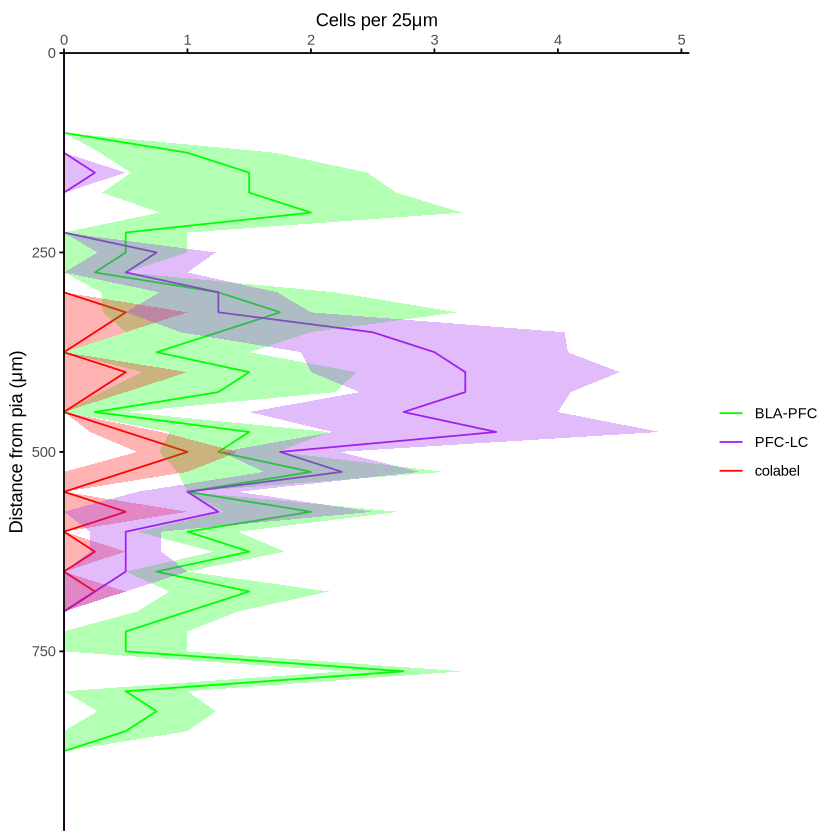

In [10]:
plot <-stats %>%
    ggplot(aes(x = min_distance, y = mean, color = projection)) +
    geom_line() +
    geom_ribbon(
        aes(ymin = lower, ymax = upper, fill = projection), 
        alpha = 0.3, show.legend = FALSE, colour = NA
    ) +
    labs(x = "Distance from pia (μm)", y = "Cells per 25μm", color = NULL) + 
    scale_color_manual(
        values = c("BLA-PFC"="green", "PFC-LC"="purple", "colabel"="red"),
        breaks = c("BLA-PFC", "PFC-LC", "colabel")
    ) +
    scale_fill_manual(values = c("BLA-PFC"="green", "PFC-LC"="purple", "colabel"="red")) +
    coord_flip() +
    scale_x_reverse(expand = expansion(mult = c(0, 0))) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.05)), position = "right") +
    theme_minimal() + 
    theme(
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.ticks = element_line(color = "black"),
        axis.line = element_line(color = "black")
    )

plot

In [13]:
ggsave(plot, filename = "plot_density.pdf", width = 3.5, height = 3, device = cairo_pdf)